# Space Invader with Advantage Actor Critic

### Import

In [87]:
import time
import gym
import cv2
import random
import torch
import numpy as np
import matplotlib.pyplot as plt
import math
import sys
sys.path.append('../../')
%matplotlib inline
from algos.agents import A2CAgent
from algos.models import ActorCnn, CriticCnn
from algos.preprocessing.stack_frame import stack_frame
from collections import deque
from IPython.display import clear_output

### Fonts

In [88]:
csfont = {'fontname':'Georgia'}
hfont = {'fontname':'Helvetica'}

### Create our environment

In [89]:
env = gym.make('SpaceInvaders-v4',render_mode='human');
env.seed(0);

### Check for CUDA

In [90]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device: ", device)

Device:  cpu


### View our Enviroment

The size of frame is:  (210, 160, 3)
No. of Actions:  6


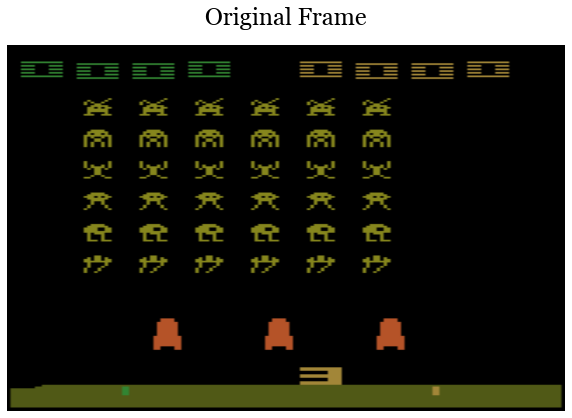

In [91]:
print("The size of frame is: ", env.observation_space.shape);
print("No. of Actions: ", env.action_space.n);
screen,info = env.reset()
screen[:,0,:] = 0
screen[:,-1,:] = 0
screen[0,:,:] = 0
screen[1,:,:] = 0
screen[-1,:,:] = 0
screen[-2,:,:] = 0
plt.figure(figsize=(10,10))
plt.imshow(screen,aspect=0.5)
plt.title('Original Frame',**csfont,fontsize=24,pad=20)
plt.axis('off');

### Execute the code cell below to play Space Invader with a random policy.

In [92]:
def random_play():
    score = 0
    env.reset()
    while True:
        env.render()
        action = env.action_space.sample()
        step = env.step(action)
        state = step[0]
        reward = step[1]
        done = step[2]
        score += reward
        if done:
            env.close()
            print("Your Score at end of game is: ", score)
            break
random_play()

### Preprocess Frame

In [93]:
def preprocess_frame(screen, exclude, output):

    screen = cv2.cvtColor(screen, cv2.COLOR_RGB2GRAY)
    screen = screen[exclude[0]:exclude[2], exclude[3]:exclude[1]]
    screen = np.ascontiguousarray(screen, dtype=np.float32) / 255
    screen = cv2.resize(screen, (output, output), interpolation = cv2.INTER_AREA)
    return screen

### Preprocess Screen

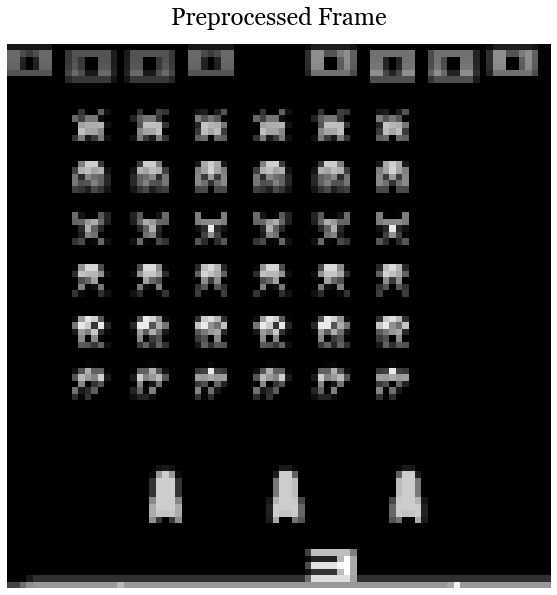

In [94]:
screen,info = env.reset()
screen = preprocess_frame(screen, (8, -12, -12, 4), 84)
plt.figure(figsize=(10,10))
plt.imshow(screen, cmap="gray");
plt.title('Preprocessed Frame',**csfont,fontsize=24,pad=20)
plt.axis('off');

### Stack Frame

In [95]:
def stack_frame(stacked_frames, frame, is_new):

    if is_new:
        stacked_frames = np.stack(arrays=[frame, frame, frame, frame])
        stacked_frames = stacked_frames
    else:
        stacked_frames[0] = stacked_frames[1]
        stacked_frames[1] = stacked_frames[2]
        stacked_frames[2] = stacked_frames[3]
        stacked_frames[3] = frame
    
    return stacked_frames

### Stack Frames

In [96]:
def stack_frames(frames, state, is_new=False):

    screen,info = state
    frame = preprocess_frame(screen, (8, -12, -12, 4), 84)
    frames = stack_frame(frames, frame, is_new)
    frames.shape
    return frames

### Creating our Agent

In [101]:
start_epoch = 0
scores = []
scores_window = deque(maxlen=20)
INPUT_SHAPE = (4, 84, 84)
ACTION_SIZE = env.action_space.n
SEED = 0
GAMMA = 0.99           # discount factor
ALPHA= 0.0001          # Actor learning rate
BETA = 0.0005          # Critic learning rate
UPDATE_EVERY = 100     # how often to update the network 
agent = A2CAgent(INPUT_SHAPE, ACTION_SIZE, SEED, device, GAMMA, ALPHA, BETA, UPDATE_EVERY, ActorCnn, CriticCnn)

### Watching untrained agent play

In [116]:
def untrained_play():
    score = 0
    while True:    
        env.render()
        action, _, _ = agent.act(state)
        step = env.step(action)
        next_state = step[0]
        reward = step[1]
        print(reward)
        done = step[2] 
        score += reward
        stack_frames(state, (next_state,info), False)
        if done:
            print("You Final score is:", score)
            break 

env.reset()
state = stack_frames(None, env.reset(), True)    
untrained_play()
env.close()

0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
5.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
You Final score is: 5.0


### Train the Agent with DQN Helper Function

In [106]:
def train(n_episodes=1000):

    for i_episode in range(start_epoch + 1, n_episodes+1):
        state = stack_frames(None, env.reset(), True)
        score = 0
        while True:
            action, log_prob, entropy = agent.act(state)
            step = env.step(action)
            next_state = step[0]
            reward = step[1]
            done = step[2]
            info = step[3]
            score += reward
            next_state = stack_frames(state, (next_state,info), False)
            agent.step(state, log_prob, entropy, reward, done, next_state)
            state = next_state
            if done:
                break
        scores_window.append(score)       # save most recent score
        scores.append(score)              # save most recent score
        
        clear_output(True)
        fig = plt.figure()
        ax = fig.add_subplot(111)
        plt.plot(np.arange(len(scores)), scores)
        plt.ylabel('Score')
        plt.xlabel('Episode #')
        plt.show()
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)), end="")
    
    return scores

### Train

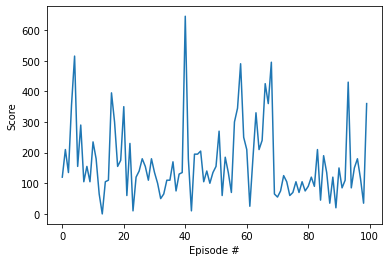

Episode 100	Average Score: 137.75

In [107]:
scores = train(100)

### Plot Results

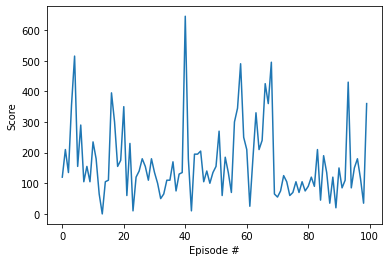

In [108]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

### Visualize AI player

In [110]:
score = 0
state = stack_frames(None, env.reset(), True)
while True:
    env.render()
    action, _, _ = agent.act(state)
    step = env.step(action)
    next_state = step[0]
    reward = step[1]
    done = step[2]
    info = step[3]
    score += reward
    state = stack_frames(state, (next_state,info), False)
    if done:
        print("You Final score is:", score)
        break 
env.close()

You Final score is: 180.0
